# Convexidade, Otimização e *Suport Vector Machines* (SVMs)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo
* Introdução
* Conjuntos e Funções Convexas
* Gradiente Descendente
  * Otimizando uma equação quadrática
* Otimização Restrita
* Mínimos Quadrados
* Convergência em Objetivos
* Convergência em Domínios
  * Caso subdeterminado $m < n$
  * $l_{2}$- mínimos quadrados regularizados
  * Regularização Implícita
* LASSO

* 1. Introdução: O que é otimização em ML?
  * Por que todo ML envolve minimizar alguma função.
  * Exemplos de problemas de otimização em ML.

* 2. Gradiente Descendente: Intuição e Definição
  * Caminho da maior descida, derivada e gradiente.
  * Algoritmo passo-a-passo.
  * Convergência em objetivo vs. domínio.

* 3. Convexidade: Definição e Implicações
  * Funções convexas, conjuntos convexos.
  * Otimalidade global e implicações para algoritmos.

* 4. Regularização Explícita e Implícita
  * Ridge/Lasso: definições formais, motivação estatística.
  * Early stopping e soluções de norma mínima como regularização implícita.

* 5. Aplicações e Simulações
  * Minimização de uma função quadrática.
  * Ajuste de regressão linear com GD.
  * Comparação entre solução analítica e iterativa.
  * Visualização do caminho da convergência.



### Referências

* [An Introduction to Statistical Learning](https://www.statlearning.com/) (ISL) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
  * Capítulo 5***
* [The Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) (ESL) by Trevor Hastie, Robert Tibshirani and Jerome Friedman : 
  * Capítulo 7

***Disclaimer:*** *O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer feedback ou sugestão de melhoria.*

In [2]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Import
import autograd.numpy as np
from autograd import grad
import seaborn as sns

# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-v0_8-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

### 1. Introdução

Nesta aula, abordamos os fundamentos matemáticos básicos da otimização convexa, com foco em sua aplicação a modelos de Machine Learning.

A otimização é uma parte essencial do aprendizado de máquina, pois envolve a minimização de funções de perda para ajustar modelos aos dados. 

Conceitos fundamentais:

* ***Aprendizado Supervisionado:*** você observa dados com respostas conhecidas (supervisão) e treina um modelo para aprender essa correspondência, generalizando para novos dados.
* ***Função de Perda (Loss Function):*** é a função que mede o quão bem um modelo se ajusta aos dados. O objetivo é minimizar essa função para melhorar a precisão do modelo.
* ***Algoritmos de Otimização:*** são métodos utilizados para encontrar os parâmetros do modelo que minimizam a função de perda.
* ***Conjuntos Convexos:*** são conjuntos onde, para quaisquer dois pontos dentro do conjunto, a linha reta que os conecta também está dentro do conjunto. Isso é importante porque muitas técnicas de otimização assumem que o espaço de parâmetros é convexo.
* ***Funções Convexas:*** são funções onde a linha reta que conecta quaisquer dois pontos da curva está acima ou na curva. Isso garante que qualquer mínimo local também seja um mínimo global, facilitando a otimização.

Vejamos um exemplo em python para ilustrar os conceitos de Conjuntos e Funções Convexas:

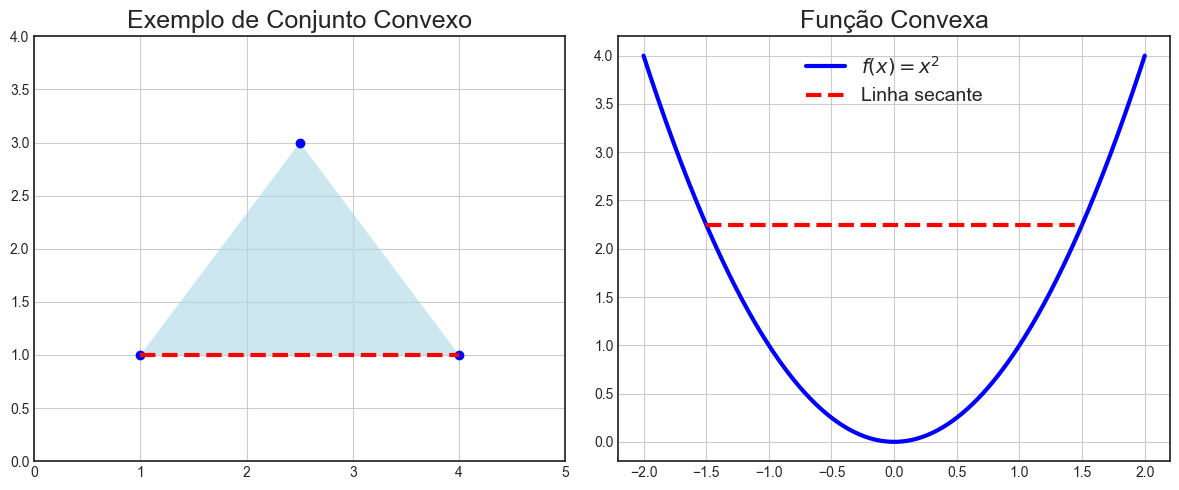

In [11]:
# Plot 1: Conjunto convexo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pontos do conjunto
points = np.array([[1, 1], [4, 1], [2.5, 3]])
axes[0].fill(points[:, 0], points[:, 1], 'lightblue', alpha=0.6)
axes[0].plot(points[:, 0], points[:, 1], 'bo')
axes[0].plot([points[0, 0], points[1, 0]], [points[0, 1], points[1, 1]], 'r--')
axes[0].set_title("Exemplo de Conjunto Convexo")
axes[0].set_xlim(0, 5)
axes[0].set_ylim(0, 4)
axes[0].set_aspect('equal')
axes[0].grid(True)

# Plot 2: Função convexa
x = np.linspace(-2, 2, 400)
y = x**2
axes[1].plot(x, y, 'b', label='$f(x) = x^2$')
# linha secante
x0, x1 = -1.5, 1.5
y0, y1 = x0**2, x1**2
axes[1].plot([x0, x1], [y0, y1], 'r--', label='Linha secante')
axes[1].set_title("Função Convexa")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


A linha vermelha pontilhada representa a reta secante entre dois pontos da função.
Se a função é convexa, ela sempre estará abaixo da secante — essa é a essência da definição formal de convexidade.

A seguir, vamos formalizar a ideia central por trás da maioria dos algoritmos de aprendizado de máquina: ajustar parâmetros para minimizar um erro medido por uma função de perda.

**Todo Machine Learning envolve minimizar alguma função?**
>
>Sim! Aprender com dados em Machine Learning significa, fundamentalmente, ajustar parâmetros para minimizar o erro entre o modelo e os dados observados.
>

Em poucas palavras, o aprendizado supervisionado é um problema de otimização:

* Temos um modelo parametrizado $f(x; \theta)$, onde $x$ são as entradas e $\theta$ são os parâmetros do modelo.
* Queremos que ele faça boas previsões $\hat{y} = f(x)$. 
* Medimos o quão ruim está a previsão com uma função de perda $l(y, \hat{y})$.
* A tarefa do modelo é:

$$ \theta_{min} = \arg\min_{\theta} \frac{1}{n} \sum_{i=1}^{n} l(y_i, f(x_i; \theta)) $$

* ou seja, encontrar os melhores parâmetros $\theta$ que minimizam a média da função de perda sobre todos os dados de treinamento.


**O procedimento de minimização de alguma função se aplica a muitos problemas de Machine Learning?**

Sim, a minimização de funções é um aspecto central em muitos problemas de Machine Learning. Aqui estão alguns exemplos:
* Regressão: Minimizar a soma dos erros quadráticos;
* Classificação: Minimizar a perda de entropia cruzada (Log Loss);
* Redes Neurais: Minimizar a função de perda através de backpropagation;
* SVM: Minimizar a norma do vetor de pesos sob restrições de margem;
* OBS: Mesmo em métodos não paramétricos (como árvores ou boosting), os algoritmos são construídos para minimizar uma loss em alguma métrica.

Assim, a base computacional de todo ML moderno é algum algoritmo de otimização, como por exemplo, gradiente descendente, métodos de Newton, Adam, SGD, etc.



### 2. Gradiente Descendente

O gradiente descendente é um dos algoritmos de otimização mais importantes e amplamente utilizados em Machine Learning. Ele serve para minimizar uma função de perda ajustando os parâmetros do modelo na direção oposta ao gradiente da função.

***Intuição Geométrica***

Imagine que você está no alto de uma montanha com os olhos vendados e deseja chegar ao ponto mais baixo (o vale). A cada passo, você consegue sentir a inclinação do terreno – e decide descer na direção mais inclinada. Esse é o princípio do gradiente descendente:

> O **gradiente** é a direção de **máximo aumento** da função. Logo, o **gradiente descendente** segue a direção oposta para **minimizá-la**.


***Formulação Matemática***

Vamos considerar uma função de perda de regressão:
$$
\mathcal{L}(\beta) = \frac{1}{n} \sum_{i=1}^{n} (y_i - f(x_i; \beta))^2
$$

onde $y_i$ são os valores reais, $f(x_i; \beta)$ é a previsão do modelo e $n$ é o número de observações. 

Para fins didáticos, vamos considerar o caso mais simples: apenas **uma observação e um único parâmetro**. Suponha:

$$
l(\beta) = (y - \beta x)^2
$$

Essa função depende apenas de $ \beta $ e é uma **parábola convexa**, com abertura para cima. Seu mínimo global ocorre exatamente no ponto:

$$\beta^{*} = \frac{y}{x} $$

Encontrar o valor ótimo de $\beta$ é, portanto, o mesmo que encontrar o ponto mais baixo da parábola.

Estamos acostumados a resolver esse problema de forma analítica, isto é, encontrando a derivada da função e igualando-a a zero para encontrar o ponto de inclinação nula (mínimo, máximo ou ponto de sela). Posteriormente, verificamos pela segunda derivada se o ponto é um mínimo ou máximo (positiva, negativa). Caso a segunda derivada seja zero, o ponto é um ponto de sela e precisamos de mais informações para determinar a natureza do ponto.

O gradiente descendente não encontra esse mínimo diretamente como na solução analítica, mas sim aproxima-se dele iterativamente, usando a inclinação da curva (primeira derivada, o gradiente) em cada ponto para decidir a direção e o tamanho do passo.

No exemplo da parábola $l(\beta) = (y - \beta x)^2$, vimos que o ponto de mínimo pode ser atingido iterativamente por meio de passos que seguem a direção contrária à inclinação da curva. Esse raciocínio pode ser generalizado para qualquer função de perda diferenciável — e é justamente isso que o algoritmo de gradiente descendente faz: ele atualiza os parâmetros do modelo dando passos sucessivos na direção de maior descida, guiado pelo gradiente da função.

***Algoritmo de Gradiente Descendente (Aproximação numérica)***

De forma geral, o gradiente descendente é um **método iterativo** para encontrar o mínimo de uma função de perda diferenciável.

Dado um vetor de parâmetros $ \theta \in \mathbb{R}^p $ e uma função de perda $ \mathcal{L}(\theta) $, o algoritmo realiza as seguintes etapas:

1. **Inicialize** $ \theta^{(0)} $ com algum valor (por exemplo, zeros ou valores aleatórios);
2. **Para cada iteração $ t $:**
   - Compute o gradiente da função de perda:  
     $$
     g^{(t)} = \nabla \mathcal{L}(\theta^{(t)})
     $$
   - Atualize os parâmetros na direção oposta ao gradiente:  
     $$
     \theta^{(t+1)} = \theta^{(t)} - \eta \cdot g^{(t)}
     $$
   - Onde $ \eta > 0 $ é a **taxa de aprendizado**, que controla o tamanho do passo.

3. **Repita** o processo até a convergência (ou até atingir um número máximo de iterações).


**Exemplo de Implementação**

Vamos implementar esse algorítmo manualmente para entender melhor como ele funciona. Vamos fazer o procedimento para três iterações do gradiente descendente, com valores explícitos:

Queremos minimizar:
$$ f(x) = x^2 $$

A derivada é
$$ f'(x) = 2x $$

Vamos assumir que começamos com $x = 3$ e uma taxa de aprendizado $\eta = 0.1$.

* Iteração 1:
$$ x^{(1)} = x^{(0)} - \eta \cdot f'(x^{(0)}) = 3 - 0.1 \cdot 2 \cdot 3 = 3 - 0.6 = 2.4 $$
* Iteração 2:
$$ x^{(2)} = x^{(1)} - \eta \cdot f'(x^{(1)}) = 2.4 - 0.1 \cdot 2 \cdot 2.4 = 2.4 - 0.48 = 1.92 $$
* Iteração 3:
$$ x^{(3)} = x^{(2)} - \eta \cdot f'(x^{(2)}) = 1.92 - 0.1 \cdot 2 \cdot 1.92 = 1.92 - 0.384 = 1.536 $$

A cada passo, o valor de $x$ se aproxima do mínimo da função, que é $x = 0$, e o valor da função $f(x)$ vai diminuindo. O gradiente descendente realiza isso sem resolver a derivada igual a zero, apenas seguindo a inclinação da função.

***Convergência***

A convergência do gradiente descendente depende da escolha da taxa de aprendizado e da forma da função:

- **Convergência em objetivo**: $ \mathcal{L}(\theta^{(t)}) \to \mathcal{L}(\theta^*) $. O valor da função de perda se aproxima do mínimo.
- **Convergência em domínio**: $ \theta^{(t)} \to \theta^* $. Os parâmetros convergem para os valores que minimizam $ \mathcal{L} $.

Se a função $ \mathcal{L} $ for **convexa**, a convergência para o mínimo global pode ser garantida.


***O gradiente descendente se torna necessário em pelo menos três situações muito comuns em Machine Learning moderno:***

* Funções complexas ou não lineares
* Muitos parâmetros (alta dimensão)
* Otimização com dados estocásticos

O gradiente descendente não é melhor em precisão, mas é mais prático, mais geral, e mais escalável — por isso, é a base de quase todo algoritmo moderno de Machine Learning.

***Verificando em Python***

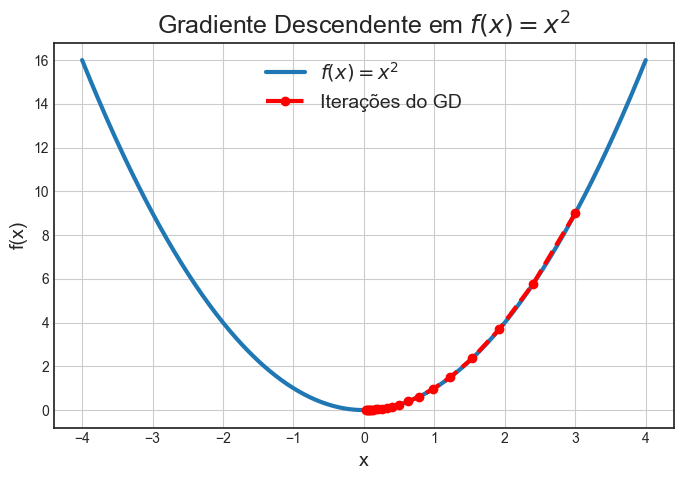

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Função e derivada
f = lambda x: x**2
grad_f = lambda x: 2*x

# Inicialização
x = 3.0  # valor inicial
eta = 0.1  # taxa de aprendizado
x_vals = [x]
f_vals = [f(x)]

# Gradiente descendente
for _ in range(20):
    x = x - eta * grad_f(x)
    x_vals.append(x)
    f_vals.append(f(x))

# Plot
x_plot = np.linspace(-4, 4, 400)
y_plot = f(x_plot)

plt.figure(figsize=(8, 5))
plt.plot(x_plot, y_plot, label="$f(x) = x^2$")
plt.plot(x_vals, f_vals, 'ro--', label="Iterações do GD")
plt.title("Gradiente Descendente em $f(x) = x^2$")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

### 3. Otimização Restrita

Na seção anterior, buscamos minimizar uma função de perda $\mathcal{L}(\theta)$ **sem nenhuma restrição** sobre os parâmetros $\theta$. No entanto, em muitas aplicações práticas de Machine Learning, a otimização ocorre **sob restrições**.

#### 3.1 Formulação Geral

Um problema de **otimização restrita** consiste em minimizar uma função objetivo, sujeita a um conjunto de **restrições** que limitam o conjunto de soluções viáveis.

A forma geral do problema é:

$$
\min_{\theta} \ \mathcal{L}(\theta) \quad \text{sujeito a:}
\begin{cases}
g_i(\theta) \leq 0, & \text{para } i = 1, \dots, m \quad \text{(restrições de desigualdade)} \\
h_j(\theta) = 0, & \text{para } j = 1, \dots, r \quad \text{(restrições de igualdade)}
\end{cases}
$$

- $\mathcal{L}(\theta)$ é a **função de perda** ou objetivo, que queremos minimizar.
- $\theta \in \mathbb{R}^p$ representa os **parâmetros** do modelo.
- As funções $g_i(\theta)$ impõem **restrições de desigualdade** (por exemplo, "o parâmetro $\theta_1$ deve ser não-negativo").
- As funções $h_j(\theta)$ impõem **restrições de igualdade** (por exemplo, "a soma dos parâmetros deve ser igual a 1").

Essas restrições definem o **conjunto viável** de soluções: apenas os valores de $\theta$ que satisfazem todas as condições são candidatos válidos à solução ótima.

Esse tipo de formulação é essencial quando queremos:
- Impor limites à magnitude dos parâmetros;
- Garantir que probabilidades somem 1;
- Restringir coeficientes a serem positivos, inteiros, etc.

#### 3.2 Exemplos de Otimização com Restrições

Agora vamos ver como alguns modelos clássicos de Machine Learning podem ser vistos como problemas de otimização com restrições explícitas.

**Exemplo 1: Ridge Regression**

Em vez de usar uma penalização direta, podemos ver a regressão Ridge como um problema de restrição na soma dos quadrados dos coeficientes:

$$
\min_{\beta} \ \frac{1}{n} \sum_{i=1}^n (y_i - x_i^\top \beta)^2 
\quad \text{sujeito a: } \sum_{j=1}^p \beta_j^2 \leq c
$$

Essa restrição impede que os coeficientes cresçam muito, o que ajuda a controlar o *overfitting*.


**Exemplo 2: LASSO**

Já o LASSO impõe uma restrição sobre a soma dos valores absolutos dos coeficientes:

$$
\min_{\beta} \ \frac{1}{n} \sum_{i=1}^n (y_i - x_i^\top \beta)^2 
\quad \text{sujeito a: } \sum_{j=1}^p |\beta_j| \leq c
$$

Essa formulação força muitos coeficientes a serem exatamente zero, promovendo **esparsidade** no modelo. 


***Observação:*** Note que tanto no LASSO quanto no Ridge, a constante $c$ não é definida diretamente pelo usuário na prática. Em vez disso, o que geralmente é especificado é o parâmetro de penalização $\lambda$ (lambda), que aparece na formulação equivalente penalizada. Assim, podemos interpretar $c=c(\lambda)$ como uma função do valor de $\lambda$. Quanto maior o $\lambda$, mais restritivo é o valor de $c$.


**Exemplo 3: Support Vector Machines (SVM)**

O SVM pode ser escrito como um problema de otimização com restrições que garantem uma **margem mínima** entre as classes:

$$
\min_{w, b} \ \frac{1}{2} \sum_{j=1}^p w_j^2 
\quad \text{sujeito a: } y_i (x_i^\top w + b) \geq 1 \quad \forall i = 1, \dots, n
$$

Aqui, a função objetivo busca um vetor \( w \) com pequena magnitude, enquanto as restrições garantem que os pontos sejam classificados corretamente com uma margem.



#### 3.3 Por que enxergar penalizações como restrições?

* ***Lambda*** (hiperparâmetro / parâmetro de penalização) é uma constante que controla a força da penalização. Quanto maior o λ, mais o modelo será forçado a manter os coeficientes pequenos ou até nulos (no caso do Lasso)
* ***Tuning*** é o processo de escolher os melhores valores para hiperparâmetros. Escolhemos através de validação cruzada. O tuning busca um equilíbrio entre um modelo com bom desempenho preditivo e boa generalização.
  
Ao escrever o problema com restrições, podemos:

* Usar ferramentas formais como os multiplicadores de Lagrange ou KKT (Karush-Kuhn-Tucker);
* Verificar condições de otimalidade, dualidade, convexidade e sensibilidade;
* Estudar regimes onde a solução muda suavemente (Ridge) ou abruptamente (Lasso).

Na prática, o pesquisador escolhe o modelo por validação cruzada. Porém, interpretar penalizações como restrições implícitas (embutida/sem restrição/ simplifica a resolução computacional) mostra que:

* Ao escolher $\lambda$, você indiretamente escolhe o "tamanho do espaço de soluções admissível".
  * Isso significa que você está restringindo o espaço de modelos possíveis.
  * Ajustar $\lambda$ (tuning) é como escolher o quão restrito o seu modelo deve ser, mesmo que você nunca diga isso diretamente com um $\leq c$.
* Isso fornece uma interpretação para o tuning: não apenas um número, mas uma limitação imposta ao modelo.

***Conexões com Outros Métodos de ML***

* Árvores de Decisão: A profundidade da árvore, o número mínimo de observações por folha, ou o ganho de informação mínimo por split podem ser interpretados como restrições sobre o espaço de modelos possíveis.

* Boosting (e.g., XGBoost, Gradient Boosting): O treinamento de Boosting também é um problema de minimização de perda, com regularização explícita.

* Redes Neurais (NNs): O treinamento envolve minimizar uma loss (e.g. cross-entropy) via gradiente descendente.
  * Regularização L2 e L1 são comuns em NNs: elas são penalizações diretas nos pesos — que também podem ser vistas como restrições sobre os parâmetros da rede.
  * Dropout pode ser interpretado como uma forma estocástica de restrição de complexidade.
  * Mesmo que o algoritmo não envolva derivadas ou gradientes, ele faz busca sob restrições.




### 4. Suport Vector Machines (SVM - Máquinas de Vetores de Suporte)

As Máquinas de Vetores de Suporte (SVM) são um algoritmo de aprendizado supervisionado, para problemas de classificação. Elas buscam encontrar o hiperplano que melhor separa as classes em um espaço de alta dimensão (maximizar a margem entre as classes). O SVM procura a fronteira que deixa a maior distância possível até os pontos mais próximos de cada classe.

Em suma, o SVM serve para:
* Classificar indivíduos com base em características $X$, criando uma fronteira ótima entre classes (tipos), mesmo em problemas com muitas variáveis ou separação não linear.

Vejamos um exemplo visual para entender melhor o conceito de SVM:

<div style="text-align:center;">
    <img src="images\Fig_9_2.png"  alt="Imagem" style="width: 650px;"/>
</div>

Nessa seção veremos que existem 3 versões básicas do SVM:

* Maximal Margin Classifier
* Support Vector Classifier (SVC)
* Support Vector Machines (não linear)

Alem disso, vamos considerar o ***SVM com mais de duas classes***, que é o caso mais comum em aplicações práticas. E, por fim, ***relacionar o SVM com regressão logística***.


#### 4.1 Versões Básicas do SVM

***Maximal Margin Classifier (MMC)***

O Maximal Margin Classifier (MMC) é o SVM mais simples, que busca encontrar um hiperplano linear que separa as classes de forma ótima. A ideia é maximizar a margem entre o hiperplano e os pontos de dados mais próximos de cada classe. 


<div style="text-align:center;">
    <img src="images\Fig_9_3.png"  alt="Imagem" style="width: 650px;"/>
</div>

Vamos formalizar o MMC. Dado um vetor de características $ x \in \mathbb{R}^p $, queremos encontrar um hiperplano definido por um vetor $ \beta $ e um escalar $ \beta_0 $, tal que a função de decisão seja:

$$
f(x) = \beta^\top x + \beta_0
$$

A predição da classe é dada por:

$$
\hat{y} = \text{sign}(f(x)) 
$$

Esse hiperplano divide o espaço em duas metades, uma para cada classe.

A **margem** é a distância entre o hiperplano e os pontos mais próximos. $y_{i} \in \{-1, +1\}$ é o rótulo da classe da observação $i$. Suponha que os dados sejam classificados corretamente por um hiperplano tal que:

$$
y_i (\beta^\top x_i + \beta_0) > 0 \quad \text{para todo } i 
$$

O produto $y_{i}f(x_{i})$ deve ser positivo, garantindo que o sinal da predição $f(x_i)$ coincida com o rótulo real $y_i$. Podemos normalizar a margem ao impor:

$$
y_i (\beta^\top x_i + \beta_0) \geq 1
$$

A distância entre um ponto $ x_i $ e o hiperplano é então:

$$
\frac{y_i (\beta^\top x_i + \beta_0)}{\|\beta\|} 
$$

OBS: a normalização pela norma de $\beta$ garante que estamos medindo a distância em unidades reais, não afetadas pela escala arbitrária de $\beta$.

Maximizar a margem equivale a minimizar $ \|\beta\| $, sujeito à restrição.

O problema se reduz a:

$$
\min_{\beta, \beta_0} \quad \frac{1}{2} \|\beta\|^2 
$$

$$
\text{sujeito a: } y_i (\beta^\top x_i + \beta_0) \geq 1, \quad \forall i 
$$

Esse é um problema de **otimização convexa com restrições lineares**. A solução depende apenas de alguns pontos — os chamados **vetores de suporte** — que são os que tocam as margens.


A ideia é simples: quanto maior a margem, mais robusta tende a ser a separação entre as classes. O Maximal Margin Classifier usa apenas os pontos mais difíceis de classificar (os vetores de suporte) para definir o hiperplano. Isso o torna sensível a outliers, mas fornece a base teórica para extensões mais flexíveis, como o Support Vector Classifier.


***Support Vector Classifier (SVC)***

O **Maximal Margin Classifier** só funciona quando os dados são *linearmente separáveis*. Mas isso raramente ocorre em aplicações reais. Para contornar esse problema, usamos o **Support Vector Classifier (SVC)**.

O SVC permite **algumas violações** na separação das classes, ou seja, ele admite que alguns pontos sejam classificados incorretamente, desde que a margem continue razoavelmente grande. Isso é feito introduzindo **variáveis de folga** $ \xi_i $ e um **parâmetro de penalização** $ C $, que controla o *trade-off* entre margem e erro.

$$
\min_{\beta, \beta_0, \xi} \quad \frac{1}{2} \|\beta\|^2 + C \sum_{i=1}^n \xi_i
$$

$$
\text{sujeito a: } y_i(\beta^\top x_i + \beta_0) \geq 1 - \xi_i, \quad \xi_i \geq 0
$$

- Quando $ C $ é **pequeno**: o modelo tolera mais violações, e a margem tende a ser maior (modelo mais regularizado).
- Quando $ C $ é **grande**: o modelo tolera menos erros, e tenta classificar corretamente o máximo de pontos (modelo mais rígido).

Um exemplo visual do SVC pode ser visto abaixo:

<div style="text-align:center;">
    <img src="images\Fig_9_7.png"  alt="Imagem" style="width: 650px;"/>
</div>

Na figura é possivel verificar que o SVM foi ajustado usando quatro valores diferentes do parâmetro de ajuste $C$ em (9.12)–(9.15). 
* O maior valor de $C$ foi usado no painel superior esquerdo, e valores menores foram usados ​​nos painéis superior direito, inferior esquerdo e inferior direito. 
* Quando $C$ é grande, há uma alta tolerância para observações que estejam no lado errado da margem, e, portanto, a margem será grande. 
* À medida que $C$ diminui, a tolerância para observações que estejam no lado errado da margem diminui, e a margem se estreita.

***Support Vector Machines (não linear)***

Quando as classes **não podem ser separadas linearmente**, mesmo com o uso do SVC, podemos usar: o **mapeamento dos dados para um espaço de maior dimensão**, onde a separação linear pode ser possível.

Vejamos visualmente como diferentes funções de kernel permitem ao SVM construir fronteiras de decisão não lineares, adaptadas à distribuição dos dados.

<div style="text-align:center;">
    <img src="images\Fig_9_9.png"  alt="Imagem" style="width: 650px;"/>
</div>


A **função de kernel** $ K(x_i, x_j) $ substitui diretamente o produto interno $ x_i^\top x_j $, permitindo trabalhar com funções $ \phi(x) $ implícitas, sem precisar computá-las explicitamente.

Os kernels mais comuns são:

- **Polinomial**:  
  $$
  K(x_i, x_j) = (1 + x_i^\top x_j)^d
  $$

- **Radial Basis Function (RBF)**:  
  $$
  K(x_i, x_j) = \exp\left(-\gamma \|x_i - x_j\|^2\right)
  $$

Esses kernels permitem criar **fronteiras altamente não lineares** entre as classes.



#### 4.2 SVM com mais de duas classes

Embora o SVM tenha sido originalmente formulado para problemas binários, podemos estendê-lo para múltiplas classes usando duas abordagens principais:
* One-vs-One (OvO): treinamos um SVM para cada par de classes.
* One-vs-Rest (OvR): treinamos um SVM para cada classe contra todas as outras.
* A previsão final pode ser feita com base em votos majoritários ou na confiança do classificador (score).

#### 4.3 SVM e Regressão Logística

* A regressão logística tende a ser melhor quando a relação entre as variáveis é próxima de linear e queremos estimar probabilidades.
* O SVM é para classificação pura, especialmente quando os dados são difíceis de separar.